# Feature Extraction


This script implements methodology used to map each plain satellite image, with the aid of its corresponding mask, to a set of features.

# Overview of Methods

The methods used for feature extraction and feature aggregation were inspired by Jean et al. (2016). The pre-trained CNN used was a PyTorch implementation of the Caffe CNN used in Jean et al. (2016). In order to extract the features for each ward, we did the following:

1. Using batches of size $8$, we passed the images through the modified VGG11 CNN as follows:
    * The data was passed through the feature extracting layers. Then through an average pooling layer.
    * Using the mask for the particular image, we then resized the mask to the same size as the output of the average pooling layer and applied it to this output.
    * The resulting output was then flattened and passed through the first 4 layers of the fully-connected layers of the CNN.
    * The output from these fully-connected layers were regarded as the features.
2. The features were then averaged across the ward (i.e. across each of the images for the ward).



# Libraries Used

In [11]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

import cv2

# Constants

In [12]:
MUNICIPALITY = 'Westonaria'

In [38]:
BASE_DIR = '../..'
DATA_DIR = os.path.join(BASE_DIR, 'data')
FEATURES_DIR = os.path.join(DATA_DIR, 'extracted_features')
IMAGE_CENTER_DIR = os.path.join(DATA_DIR, 'image_centers')
IMAGE_DIR = os.path.join(DATA_DIR, 'images', MUNICIPALITY)
CNN_DIR = os.path.join(BASE_DIR, 'models', 'trained_model.pt')
# CNN_IMAGE_DIR = os.path.join(BASE_DIR, 'images', MUNICIPALITY)

In [39]:
df_ward_centers = pd.read_csv(os.path.join(IMAGE_CENTER_DIR, "{}_ward_image_centers.csv".format(MUNICIPALITY))) 
N_WARDS = df_ward_centers.shape[0]
N_WARDS

16

# Feature extract with CNN

Enabling GPU if one is available:

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} as backend')

Using cpu as backend


Loading pre-trained CNN. The model weights can be found at: https://drive.google.com/drive/folders/1gZZ1NoKaq43znWIBjzmrLuMQh4uzu9qn?usp=sharing.

In [ ]:
model = torch.load(CNN_DIR, map_location=device)

### CNN architecture used

Full model:

In [17]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

Model which we will use:

In [18]:
# rip off the final fully-connected layer
model.classifier = model.classifier[:4]
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

The images are passed through the feature extractor, then the average pooling and the layers of the classifier serve as dimension reduction.

However, since we need to isolate an ROI from the features extracted, we breakdown the layers into their specific components, namely: feature extracting layers, average pooling layer and the classifier layers. By doing this, we can insert operations between the layers before feeding the data back into the next layer.

Feature extracting layers:

In [19]:
mod_get_features = model.features[:30]
mod_get_features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

Isolating the section of the classifier which we will use:

In [20]:
mod_reduce_dim = model.classifier
mod_reduce_dim

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)

Thus, the layers can be summarised as follows:

In [21]:
# eval() ensures only forward pass is run 
mod_get_features.eval()
adapt_ave = nn.AdaptiveAvgPool2d((7,7))
mod_reduce_dim.eval()

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)

Creating a dataframe to store all the aggregated features:

In [22]:
feat_names = [str(i) for i in range(4096)]
cols = ["ward_no.", "Municipality"]
cols.extend(feat_names)
features_df = pd.DataFrame(0, index=np.arange(N_WARDS), columns=cols)
features_df["ward_no."] = np.arange(1, N_WARDS+1)
features_df.set_index('ward_no.', inplace=True)
features_df['Municipality'] = MUNICIPALITY
features_df.head()

,Municipality,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
ward_no.,,,,,,,,,,,,,,,,,,,,,
1,Westonaria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Westonaria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Westonaria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Westonaria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Westonaria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
transformer = transforms.Compose([
            transforms.ToTensor(),                                                 # converting img to tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])     # normalizing tensor pixels
        ])

# custom dataset for fast image loading and processing
class ForwardPassDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transformer):
        self.image_dir = image_dir
        self.image_list = os.listdir(self.image_dir)
        self.transformer = transformer

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_name = self.image_list[index]

        # Load image
        X = self.filename_to_im_tensor(self.image_dir + '/' + image_name)
        
        # dataloaders need to return a label, but for the forward pass we don't really care
        return X, -1
    
    def filename_to_im_tensor(self, file):
        im = plt.imread(file)[:,:,:3]
        im = self.transformer(im)
        return im

In [32]:
# setting activations outside of the ROI to zero
def isolate(img, inds):
    img[inds] = 0
    return img

In [33]:
# using the mask to select which pixels in the feature maps fall within the ward boundaries
def apply_mask(filter_maps, img_num, img_name, ward_num):
    mask = cv2.imread(os.path.join(IMAGE_DIR, 'ward_'+ str(ward_num), 'masks', img_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (7, 7), interpolation = cv2.INTER_AREA)
    thresh = 127.6      # more evidence it's in ROI than out
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]
    inds_out_ROI = np.where(mask == 0)   # pixels indices that are outside of the ROI
    return(torch.stack([isolate(img, inds_out_ROI) for img in filter_maps]))

In [34]:
# isolating the roi in the feature maps for all of the images
def isolate_roi(outputs, ind, image_order, ward_num):
    if (ind + 8) >= len(image_order):
        img_list = image_order[ind:]
    else:
        img_list = image_order[ind:ind+8]
    outputs_copy = outputs.detach().clone()
    return(torch.stack([apply_mask(img_filters, i, img_list[i], ward_num) for i, img_filters in enumerate(outputs_copy)]))

In [35]:
# flattening before passing to fully connected layers
def flatten_maps(filter_maps):
    flattened_maps = torch.stack([img_filter_map.flatten().reshape(1, 25088) for img_filter_map in filter_maps], axis=0)
    return(flattened_maps)

In [36]:
for ward_num in range(1, N_WARDS+1):
    print('Ward {} started'.format(ward_num))
    outputs = []    
    image_order = []
    dataset = ForwardPassDataset(os.path.join(IMAGE_DIR, 'ward_' + str(ward_num), 'edited'), transformer)   # loading dataset using custom class
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)           # loading data into an iterator
    image_order = dataset.image_list                                                                        # the order the images were passed in
    # shape of final array will be (num_validation_images, 4096)
    feats = np.zeros((len(dataset.image_list), 4096))                                                       # temporary storage of features for each image in batch

    i = 0
    ind_for_batch_start = 0
    for inputs, _ in tqdm(dataloader):
        inputs = inputs.to(device)                                                              # either attaching to CPU or GPU
        outputs = mod_get_features(inputs)                                                      # output at end of feature extracting layers
        outputs = adapt_ave(outputs)                                                            # adaptive ave pooling
        isolated_filter_maps = isolate_roi(outputs, ind_for_batch_start, image_order, ward_num) # isolate ROI in feature maps
        flattened_filter_maps = flatten_maps(isolated_filter_maps)                              # flatten feature maps
        features = mod_reduce_dim(flattened_filter_maps)                                        # run through section of classifier
        feats[i:i+len(inputs),:] = features.detach().numpy().reshape(len(inputs), 4096)         # reshape and save
        i += len(inputs)
        ind_for_batch_start += 8
    aggregated_feats = feats.mean(axis=0)                              # aggregate the features for all the images in the ward
    features_df.loc[ward_num, 1:] = aggregated_feats                   # save the aggregated features

Ward 1 started



Ward 2 started



Ward 3 started



Ward 4 started



Ward 5 started



Ward 6 started



Ward 7 started



Ward 8 started



Ward 9 started



Ward 10 started



Ward 11 started



Ward 12 started



Ward 13 started



Ward 14 started



Ward 15 started



Ward 16 started


In [37]:
features_df

,Municipality,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
ward_no.,,,,,,,,,,,,,,,,,,,,,
1,Westonaria,0.096781,0.003440,-0.236108,0.089861,-0.134225,-0.272444,0.162533,0.121560,0.166729,...,-0.297878,-0.423806,-0.052416,0.319357,-0.225095,0.013250,-0.050921,0.366031,-0.168184,-0.774771
2,Westonaria,0.306916,-0.241975,-0.154625,-0.009620,-0.160127,-0.447993,-0.049641,0.060570,0.393143,...,-0.417358,-0.667832,0.082522,0.165351,-0.233601,0.166103,-0.268953,0.543392,-0.380450,-0.898933
3,Westonaria,-0.360296,-0.382229,0.152973,0.158676,0.034267,-0.697517,-0.012101,0.004012,0.867822,...,-0.119086,-0.675992,0.196870,0.011772,-0.382751,-0.018210,0.164048,0.575916,-0.067541,-1.133740
4,Westonaria,-1.186264,-0.127032,0.199597,-0.147437,-0.197519,-0.794180,-0.250623,-0.433586,0.878045,...,-0.382063,-0.270026,0.272623,-0.057088,-0.102101,-0.375784,-0.291582,0.661000,0.202095,-1.350090
5,Westonaria,0.243265,-0.016028,-0.257297,0.027951,-0.279505,-0.364030,0.263318,0.069135,0.170524,...,-0.410493,-0.607444,0.064537,0.351537,-0.222613,-0.028964,-0.083043,0.494657,-0.225303,-0.797893
6,Westonaria,-0.039429,0.030722,-0.149333,0.058621,-0.145692,-0.340251,0.113386,-0.051804,0.413319,...,-0.388286,-0.454848,0.103185,0.211901,-0.140844,-0.056940,-0.034313,0.360491,-0.227074,-0.853903
7,Westonaria,-0.550606,0.190787,-0.515398,-0.086074,-0.341502,-0.798701,0.165386,-0.209897,0.390754,...,-0.322507,-0.467701,0.175373,-0.040006,0.086389,-0.326384,-0.067370,0.285212,0.097383,-0.935336
8,Westonaria,-0.135775,0.044919,-0.284921,0.009776,-0.147666,-0.327262,0.270788,0.011644,0.306067,...,-0.119891,-0.299243,-0.016493,0.209353,0.066813,-0.039673,0.020982,0.211888,0.019363,-0.665014
9,Westonaria,0.183285,-0.031020,-0.213004,0.028336,-0.178695,-0.155288,0.361173,0.308782,0.119009,...,-0.272411,-0.493900,-0.007524,0.375801,-0.013770,0.022285,0.137397,0.387322,-0.050310,-0.716024


In [183]:
# uncomment line below to write municipality's features to csv
# features_df.to_csv(os.path.join(FEATURES_DIR, '{}_features.csv'.format(MUNICIPALITY)))

### Then run the following code chunks once the features for each municipality have been extracted.

In [41]:
MUNICIPALITIES = [
    'Emfuleni',
    'Merafong City',
    'Midvaal',
    'Lesedi',
    'Mogale City',
    'Ekurhuleni',
    'Randfontein',
    'City of Tshwane',
    'City of Johannesburg',
    'Westonaria'
    ]

Joining all of the feature vectors together to **create one feature set**.

In [79]:
df_all_feats = pd.read_csv(os.path.join(FEATURES_DIR, "{}_features.csv".format(MUNICIPALITIES[0])))
for municipality in MUNICIPALITIES[1:]:
    df = pd.read_csv(os.path.join(FEATURES_DIR, "{}_features.csv".format(municipality)))
    df_all_feats = df_all_feats.append(df, ignore_index=True)

Thus, we obtain the final feature set with shape **(508, 4098)**

In [80]:
print(df_all_feats.shape)
df_all_feats

(508, 4098)


,ward_no.,Municipality,0,1,2,3,4,5,6,7,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,1,Emfuleni,-0.720134,-0.011752,-0.196956,-0.188181,-0.185301,-0.589358,0.190067,-0.182576,...,-0.383296,-0.362654,0.125460,0.021607,-0.279668,-0.002370,-0.097725,0.340595,-0.005517,-1.081248
1,2,Emfuleni,-0.648677,0.196469,-0.046444,-0.203042,0.077324,-0.685668,-0.128859,-0.162891,...,-0.434731,-0.222764,0.109085,0.066180,0.099601,-0.421368,-0.092743,0.219308,0.142782,-0.888951
2,3,Emfuleni,-0.779101,0.049304,0.334525,-0.348373,-0.081809,-0.724423,-0.346990,-0.049666,...,-0.457215,-0.106087,-0.066711,0.066039,-0.171572,-0.420311,-0.069101,0.332208,0.233605,-0.915926
3,4,Emfuleni,-0.601808,-0.065139,0.147482,-0.336250,-0.109590,-0.644383,-0.399426,-0.101277,...,-0.391497,-0.179220,0.148247,0.168646,-0.220085,-0.264893,-0.330374,0.462983,0.028194,-0.952793
4,5,Emfuleni,-1.026684,-0.286151,0.411765,-0.535642,-0.197247,-0.962774,-0.467955,-0.328909,...,-0.445696,-0.170309,-0.023123,0.089037,-0.367245,-0.257600,-0.490463,0.609728,0.084688,-1.292101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,12,Westonaria,-0.222398,-0.141817,-0.276797,0.016500,-0.122263,-0.358325,0.234763,0.001946,...,-0.190079,-0.444817,0.171839,0.324380,-0.022720,-0.023371,-0.008539,0.239722,-0.079562,-0.888998
504,13,Westonaria,-0.558968,0.090068,-0.184560,-0.084249,0.028328,-0.686811,-0.045689,-0.350774,...,-0.264312,0.101318,0.312630,0.087063,0.352885,-0.226631,-0.348637,0.078500,-0.167990,-0.614116
505,14,Westonaria,-0.128230,-0.022278,-0.105597,-0.070552,0.000291,-0.346996,0.146102,-0.094336,...,-0.052600,0.158115,0.180540,0.160432,0.164208,-0.020631,-0.098002,-0.086387,-0.122409,-0.370801
506,15,Westonaria,0.014080,0.030521,-0.255915,0.079258,-0.142167,-0.267965,0.309848,0.054331,...,-0.221932,-0.354807,-0.011939,0.364892,0.010895,-0.047921,0.055216,0.328025,-0.021046,-0.661670


In [81]:
# uncomment line below to write final feature set to csv
# df_all_feats.to_csv(os.path.join(FEATURES_DIR, 'all_features.csv'))

## Visualizations for Report

### Masking Feature Maps

This section serves to clarify how the convolutional feature masking was performed.

In [57]:
def plot_fig(img):
    img_matplot = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5))
    plt.imshow(img_matplot, cmap="gray")

In [58]:
ward_num = 11
img_name = '0_1.png'

Reading in a **satellite image**:

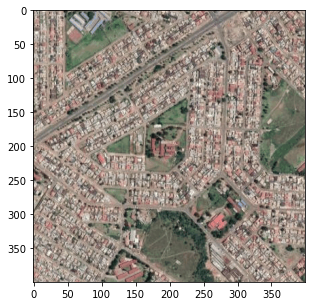

In [47]:
im = cv2.imread(os.path.join('demo_images', 'edited', img_name))
plot_fig(im)

Reading in its corresponding **mask**:

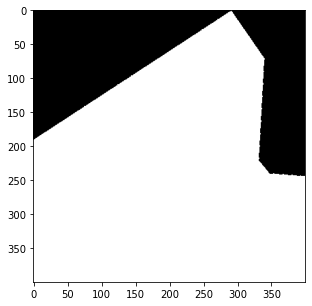

In [59]:
mask = cv2.imread(os.path.join('demo_images', 'masks', img_name), cv2.IMREAD_GRAYSCALE)
plot_fig(mask)

The ultimate goal is to use the mask to **isolate the ROI in the feature maps**.

An equivalent way to read in the above image-pair, is using the data loader defined previously:

In [50]:
dataset = ForwardPassDataset(os.path.join('demo_images', 'edited'), transformer)   # loading dataset using custom class
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)               # loading data into an iterator

We can see that, after the average pooling layer, there are **512 feature maps** of **size 7x7**, as expected.

In [51]:
for inputs, _ in tqdm(dataloader):
    outputs = mod_get_features(inputs)                                                      # output at end of feature extracting layers
    outputs = adapt_ave(outputs)                                                            # adaptive ave pooling
    print(outputs.shape)

torch.Size([1, 512, 7, 7])



A single feature map has been plotted below:

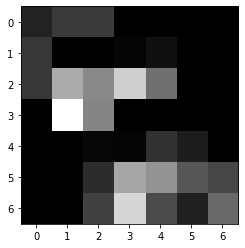

In [53]:
conv_filter = outputs[0][120].detach().numpy()
plt.imshow(conv_filter, cmap="gray")

This feature map will not be masked (i.e. the region outside of the ROI will be set to zero).

To determine which pixels are outside the ROI, the **masks are resized**:

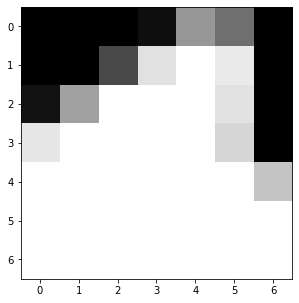

In [60]:
mask = cv2.resize(mask, (7, 7), interpolation = cv2.INTER_AREA)
plot_fig(mask)

But, it is evident that this is no longer binary. So the masks are **thresholded**:

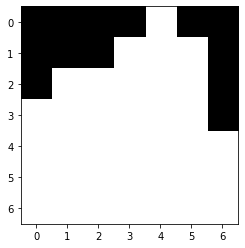

In [61]:
thresh = 127.6      # more evidence it's in ROI than out
mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]
plt.imshow(mask, cmap='gray')

The feature map pixels outside of the ROI are then set to zero. The resulting **masked feature map** can be seen below:

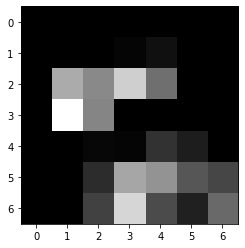

In [63]:
conv_filter[np.where(mask == 0)] = 0
plt.imshow(conv_filter, cmap="gray")

However, this is just one of the 512 convolutional feature maps. They are all visualized below:

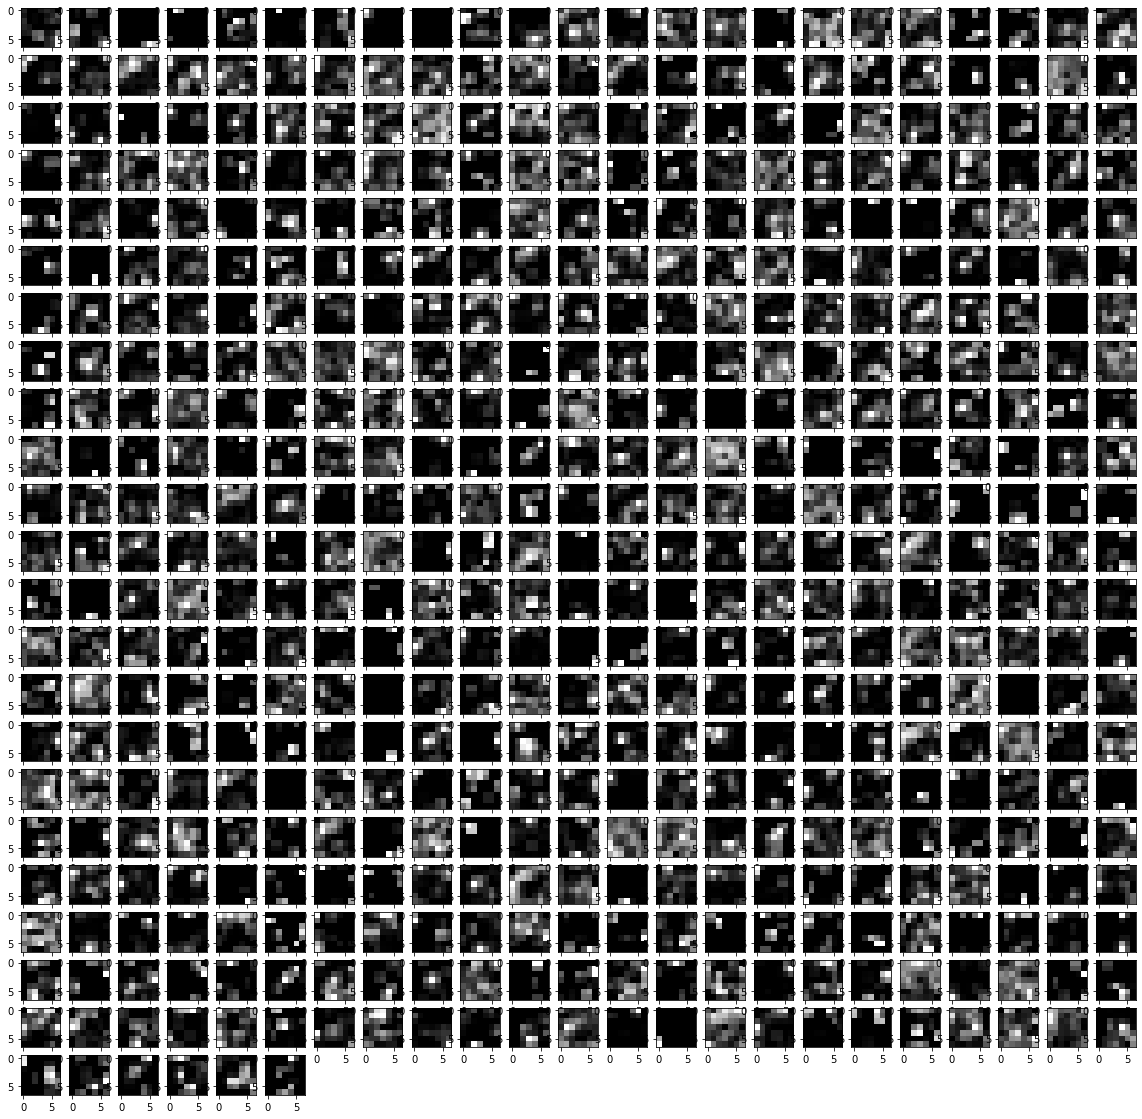

In [56]:
img_index = 0
plt.figure(figsize=(20, 20))
for i, conv_map in enumerate(outputs[0]):
    plt.subplot(23, 23, i+1)                            # (8, 8) because in conv0 we have 7x7 filters
    plt.imshow(conv_map.detach().numpy(), cmap='gray')

Below is an illustration of the creation of another masked convolutional feature map:

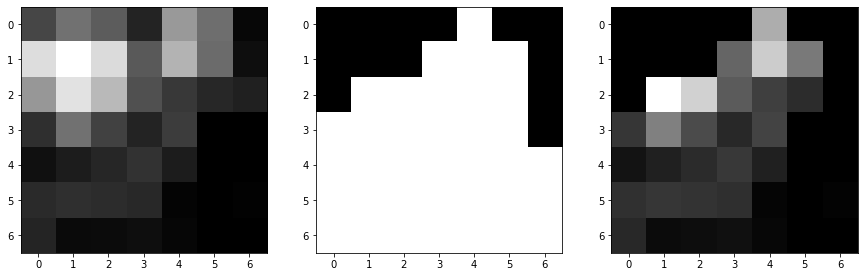

In [119]:
plt.figure(figsize=(15, 15))

out = outputs[img_index][120].detach().numpy()

plt.subplot(1, 3, 1)
plt.imshow(out, cmap="gray")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')

out[np.where(mask == 0)] = 0
plt.subplot(1, 3, 3)
plt.imshow(out, cmap="gray")

This feature map masking is applied to all of the 512 feature maps.

### Visualizing Conv Filter

A rough way of visualizing what the CNN regards as "features" is by **visualizing the activations** in one of its convolutional layers (we use the 5th conv layer). 

In [65]:
dataset = ForwardPassDataset(os.path.join('demo_images', 'edited'), transformer)                             # loading dataset using custom class
dataloader = torch.utils.data.DataLoader(dataset, batch_size=14, shuffle=False, num_workers=1)               # loading data into an iterator

Keeping only the layers up until the **5th conv layer**.

In [67]:
mod_vis_features = model.features[:18]
mod_vis_features.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [68]:
for inputs, _ in tqdm(dataloader):
    outputs = mod_vis_features(inputs)                                                      # output at end of feature extracting layers                                                          # adaptive ave pooling
    print(outputs.shape)

torch.Size([1, 512, 50, 50])



Notice that each of the convolutional feature maps are now of **size 50x50** compared to the 7x7 above.

In [70]:
img_index = 0

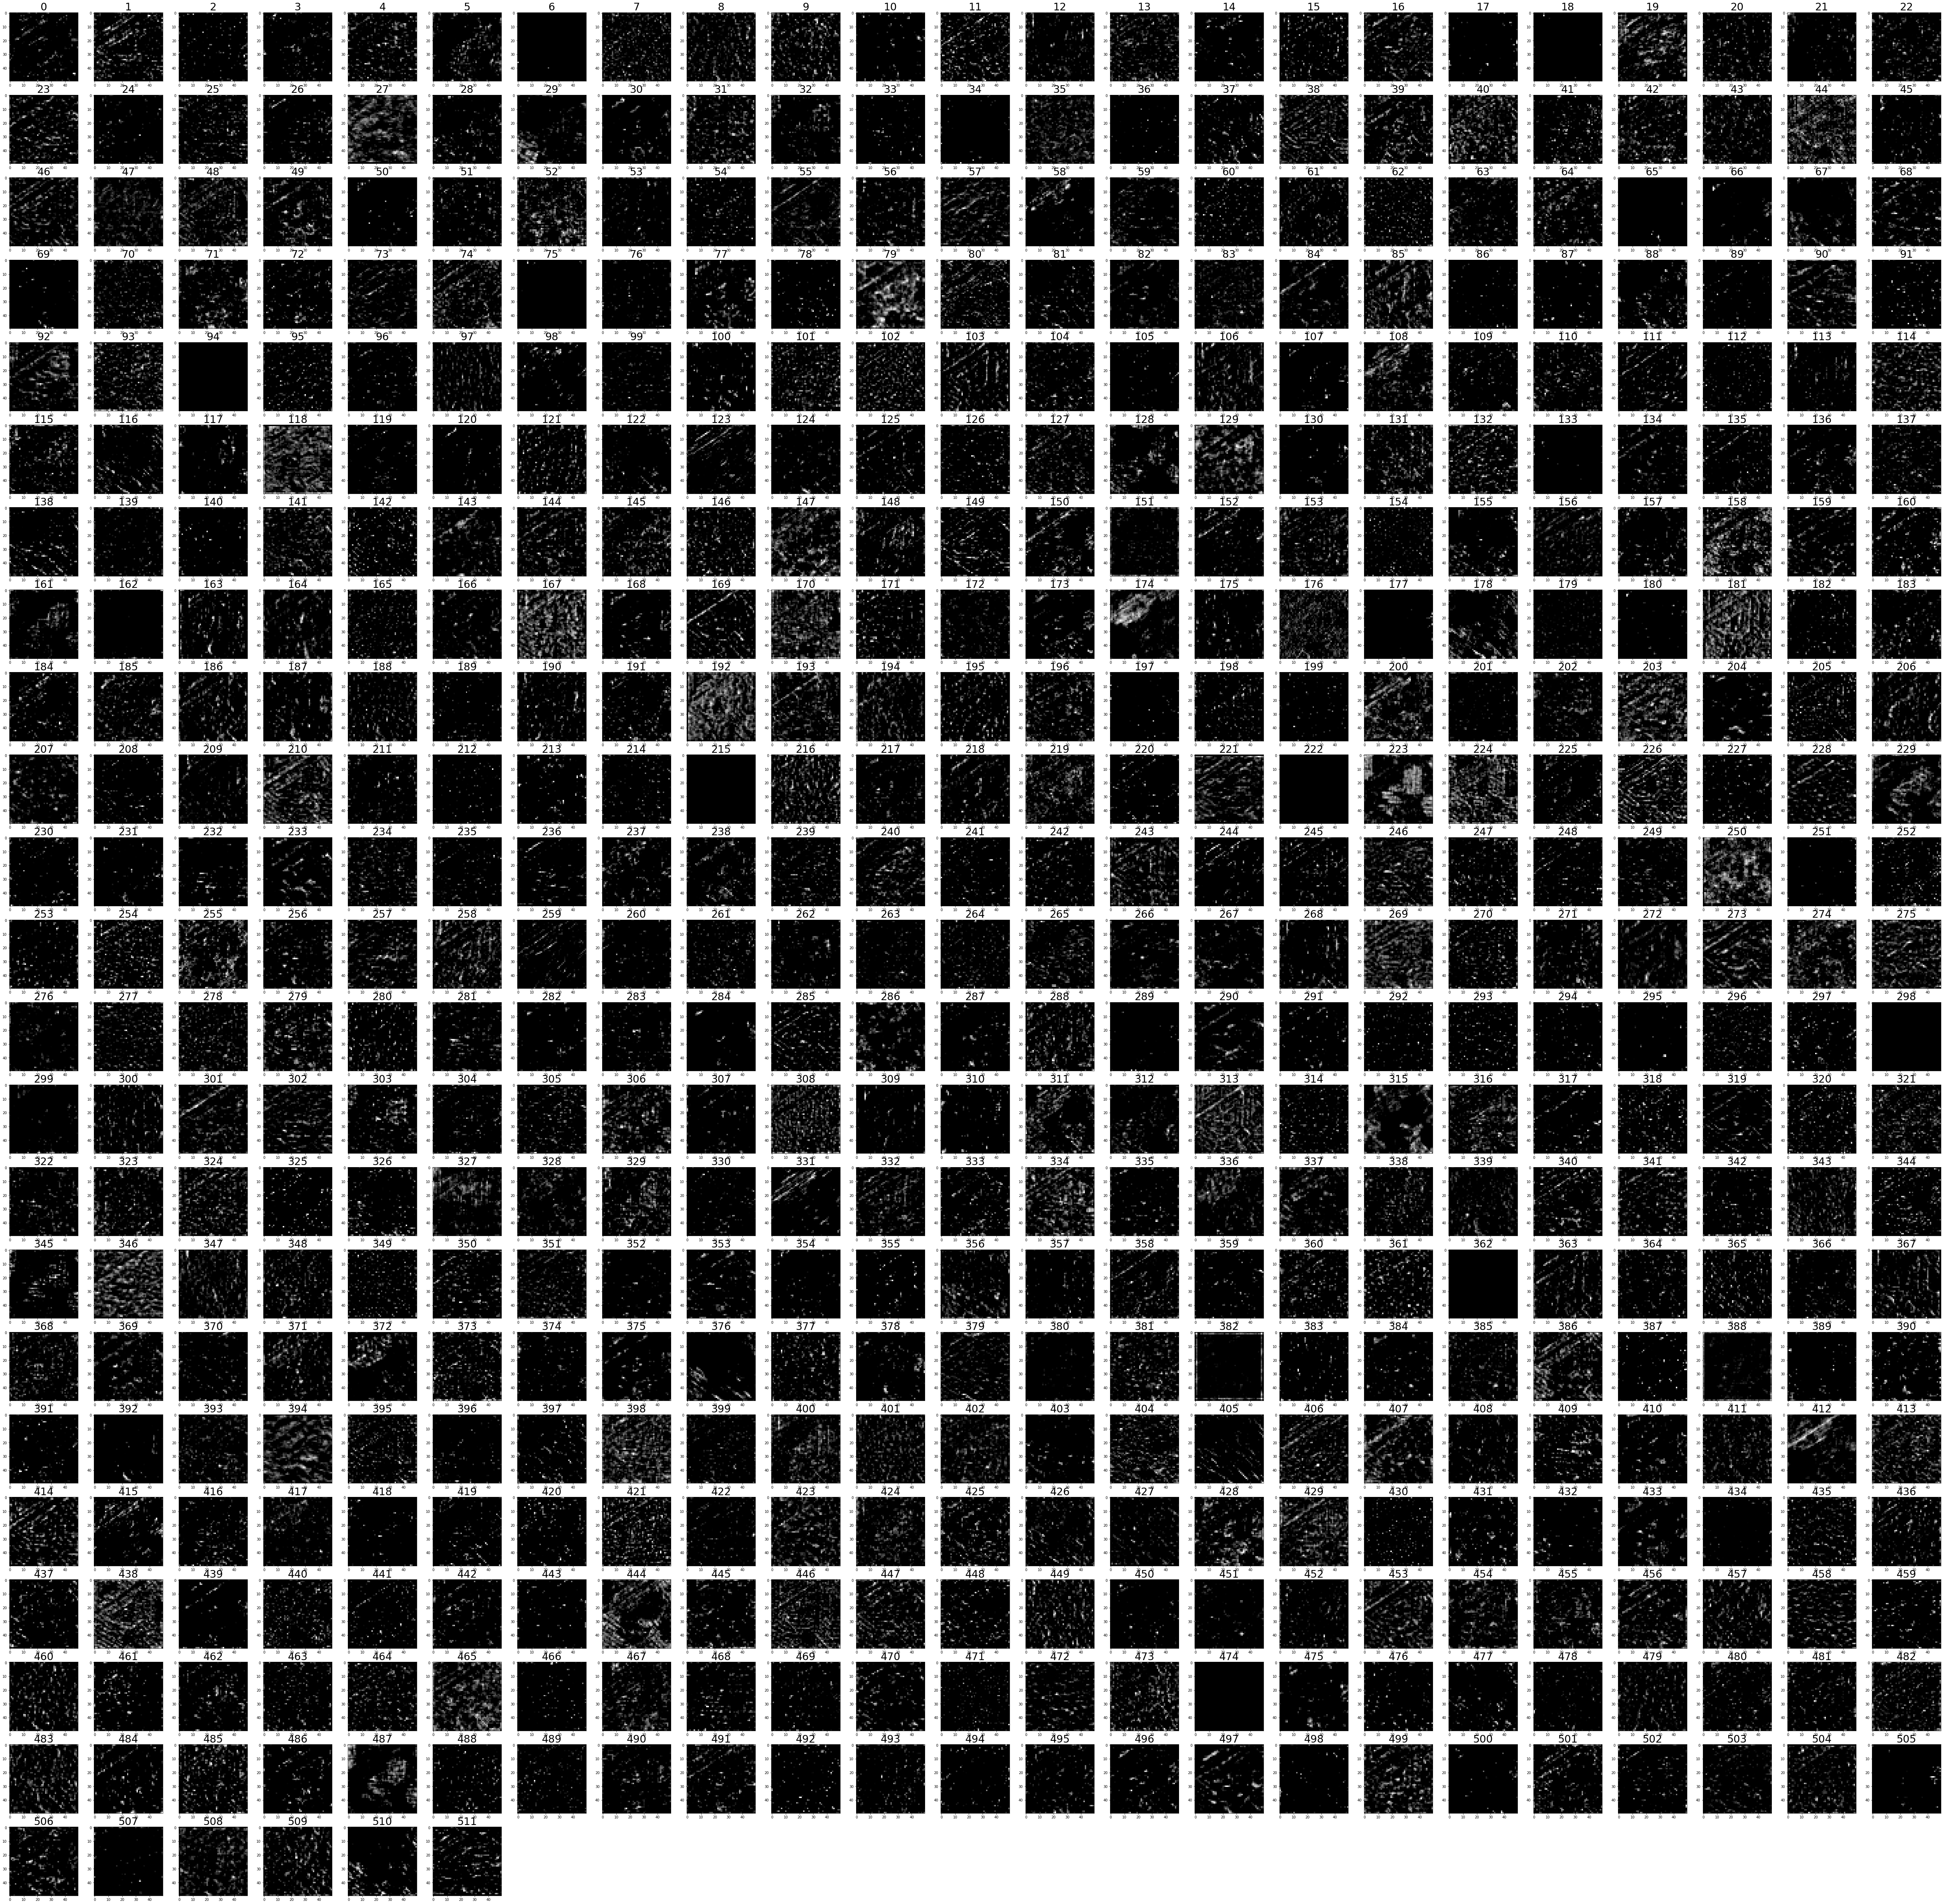

In [78]:
plt.figure(figsize=(100, 100))

for i, conv_map in enumerate(outputs[img_index]):
    plt.subplot(23, 23, i+1) 
    plt.title(str(i), {"fontsize":30})
    plt.imshow(conv_map.detach().numpy(), cmap='gray')

Visualizing the activations in the 439th feature map, it appears that it is picking up urban areas. 

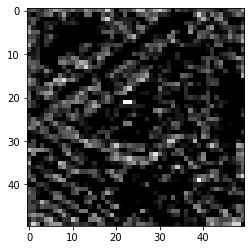

In [77]:
plt.imshow(outputs[img_index][438].detach().numpy(), cmap="gray")